In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/dataset


/content/drive/MyDrive/Colab Notebooks/dataset


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Colab Notebooks/dataset...,knight-resize
1,/content/drive/MyDrive/Colab Notebooks/dataset...,pawn_resized
2,/content/drive/MyDrive/Colab Notebooks/dataset...,Rook-resize
3,/content/drive/MyDrive/Colab Notebooks/dataset...,bishop_resized
4,/content/drive/MyDrive/Colab Notebooks/dataset...,knight-resize


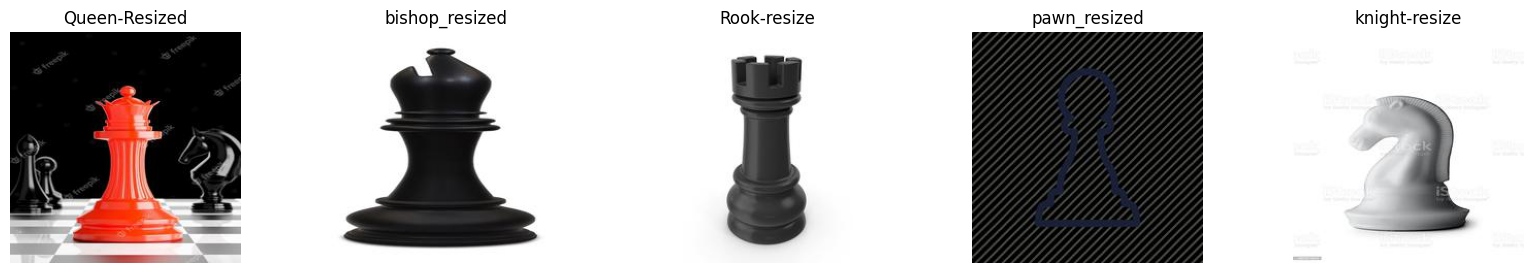

In [6]:
file_path = '/content/drive/MyDrive/Colab Notebooks/dataset'
fig, axs = plt.subplots(1,5,figsize=(20,3))
for i,x in enumerate(os.listdir(file_path)):
    img_path = file_path+'/'+ x + '/' + random.choice(os.listdir(file_path+'/'+x))
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(x)
plt.show()


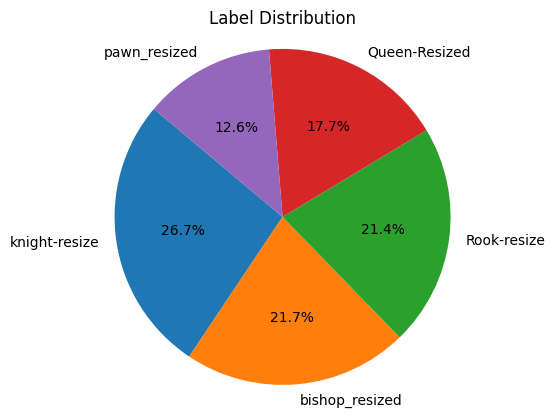

In [7]:
#visualising distribution
counts = data.Labels.value_counts()

# Create a pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')

plt.title('Label Distribution')
plt.show()

In [25]:
#train and test splitting
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)
def func(pre, name_model, size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size, size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size, size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size, size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)

    pre_model = name_model(input_shape=(size, size, 3),
                           include_top=False,
                           weights='imagenet',
                           pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    my_callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')]

    history = model.fit(train_gen, validation_data=valid_gen, epochs=100, callbacks=my_callbacks, verbose=0)
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()

    # Predict Data Test
    pred = model.predict(test_gen)
    pred = np.argmax(pred, axis=1)
    labels = train_gen.class_indices
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]

    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm = confusion_matrix(test_df.Labels, pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)

    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})

    reasons = {
        "pawn_resized": "Pawn has a circular head top",
        "Rook-resize": "Rook has a castle tower top.",
        "knight-resize": "Knight has a horse-like top.",
        "bishop_resized": "Bishop has a pointed top.",
        "Queen-Resized": "Queen has a crown-like top.",
        "king_resized": "King has a cross-like top."
    }

    for i, ax in enumerate(axes.flat):
        img = plt.imread(test_df.File_Path.iloc[i+1])
        ax.imshow(img)
        true_label = test_df.Labels.iloc[i+1]
        predicted_label = pred[i+1]

        reason = reasons.get(true_label, "Reason for this piece is not defined.")
        title = f"True: {true_label}\nPredicted: {predicted_label}\nReason: {reason}" if true_label == predicted_label else f"True: {true_label}\nPredicted: {predicted_label}\nReason: Incorrect Prediction"
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))

    return results


#####~Model => <function ResNet50 at 0x79bd329b77f0> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
              Plotting Accuracy, val_accuracy, loss, val_loss 


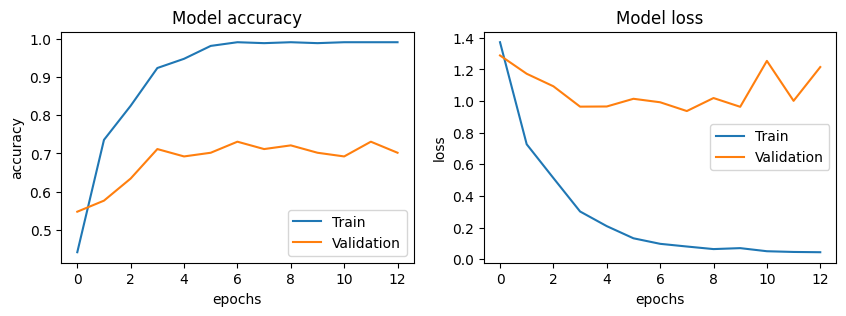

5/5 [==============================] - 7s 858ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.60      0.53      0.56        17
   Rook-resize       0.91      0.69      0.78        29
bishop_resized       0.58      0.44      0.50        34
 knight-resize       0.74      1.00      0.85        32
  pawn_resized       0.40      0.53      0.45        19

      accuracy                           0.66       131
     macro avg       0.65      0.64      0.63       131
  weighted avg       0.67      0.66      0.65       131

 Display 6 pictures of the dataset with their labels 


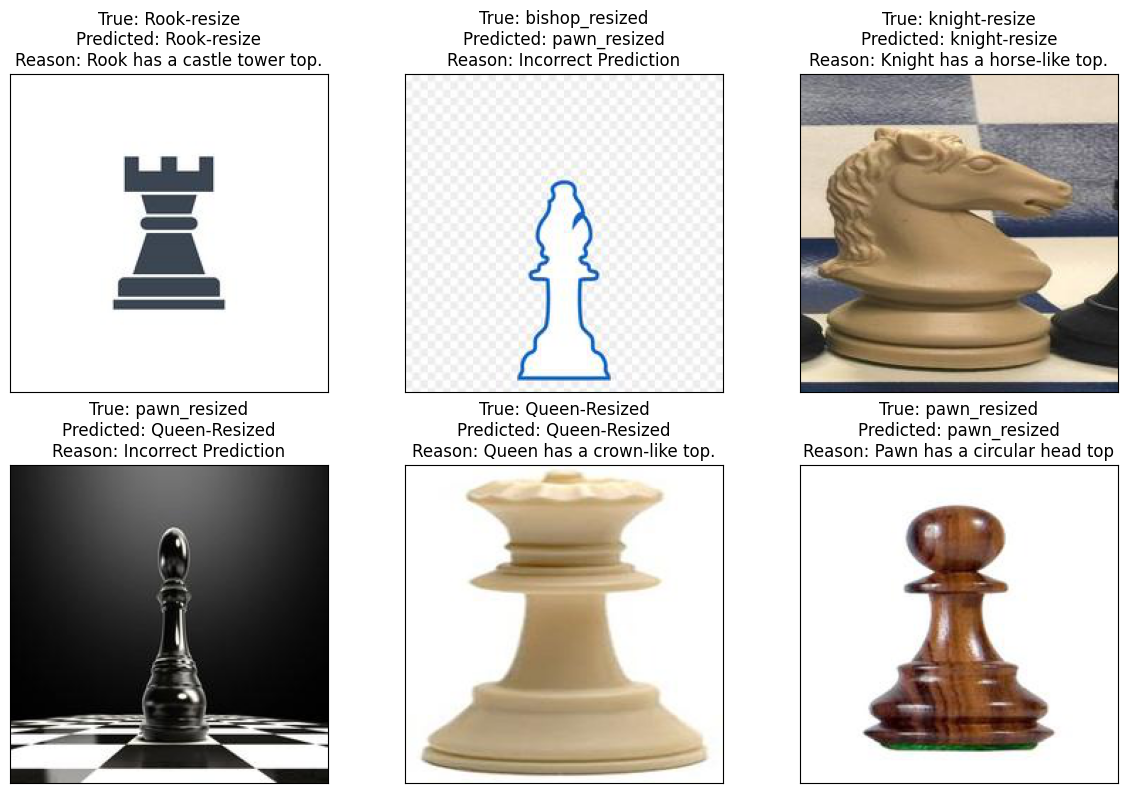

              Results 
    Test Loss:  1.08692  
Test Accuracy:  65.65%  


In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet50 = func(preprocess_input,ResNet50,100)


#####~Model => <function InceptionResNetV2 at 0x79bd329b4ee0> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
              Plotting Accuracy, val_accuracy, loss, val_loss 


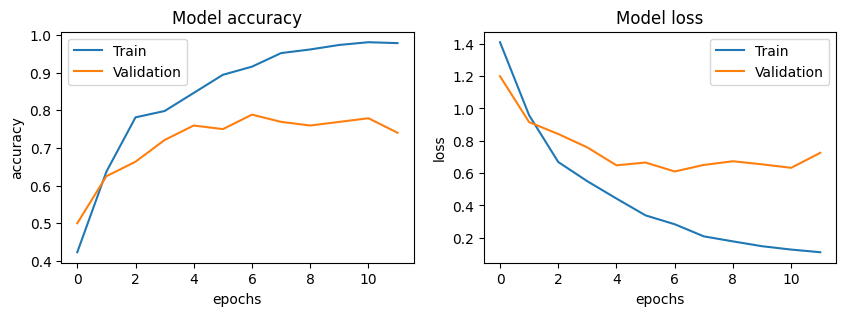

5/5 [==============================] - 35s 6s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.73      0.65      0.69        17
   Rook-resize       0.92      0.76      0.83        29
bishop_resized       0.71      0.79      0.75        34
 knight-resize       0.71      1.00      0.83        32
  pawn_resized       1.00      0.47      0.64        19

      accuracy                           0.77       131
     macro avg       0.81      0.73      0.75       131
  weighted avg       0.80      0.77      0.76       131

 Display 6 pictures of the dataset with their labels 


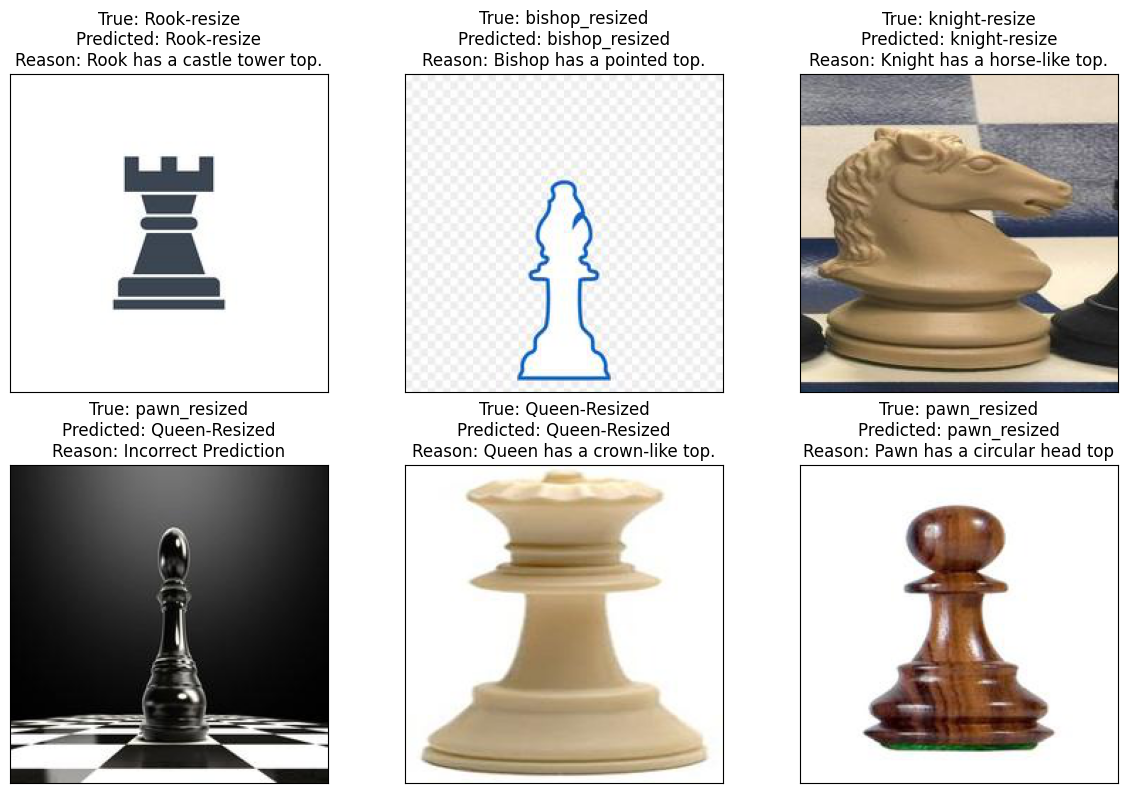

              Results 
    Test Loss:  0.89405  
Test Accuracy:  77.10%  


In [27]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InceptionResNetV2 = func(preprocess_input,InceptionResNetV2,224)


#####~Model => <function DenseNet201 at 0x79bd32997880> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
              Plotting Accuracy, val_accuracy, loss, val_loss 


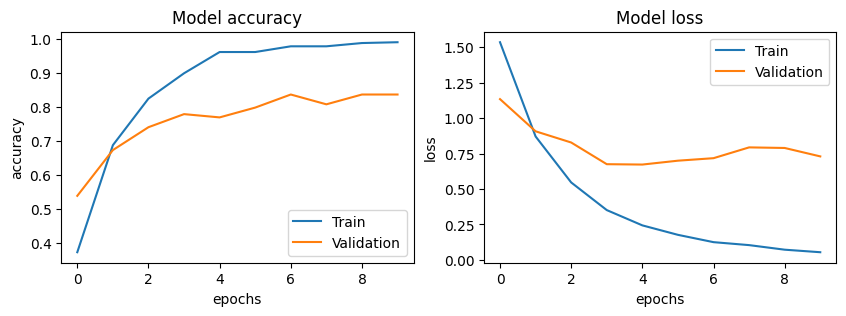

5/5 [==============================] - 9s 886ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.52      0.65      0.58        17
   Rook-resize       0.79      0.66      0.72        29
bishop_resized       0.70      0.68      0.69        34
 knight-resize       0.82      1.00      0.90        32
  pawn_resized       0.93      0.68      0.79        19

      accuracy                           0.75       131
     macro avg       0.75      0.73      0.73       131
  weighted avg       0.76      0.75      0.75       131

 Display 6 pictures of the dataset with their labels 


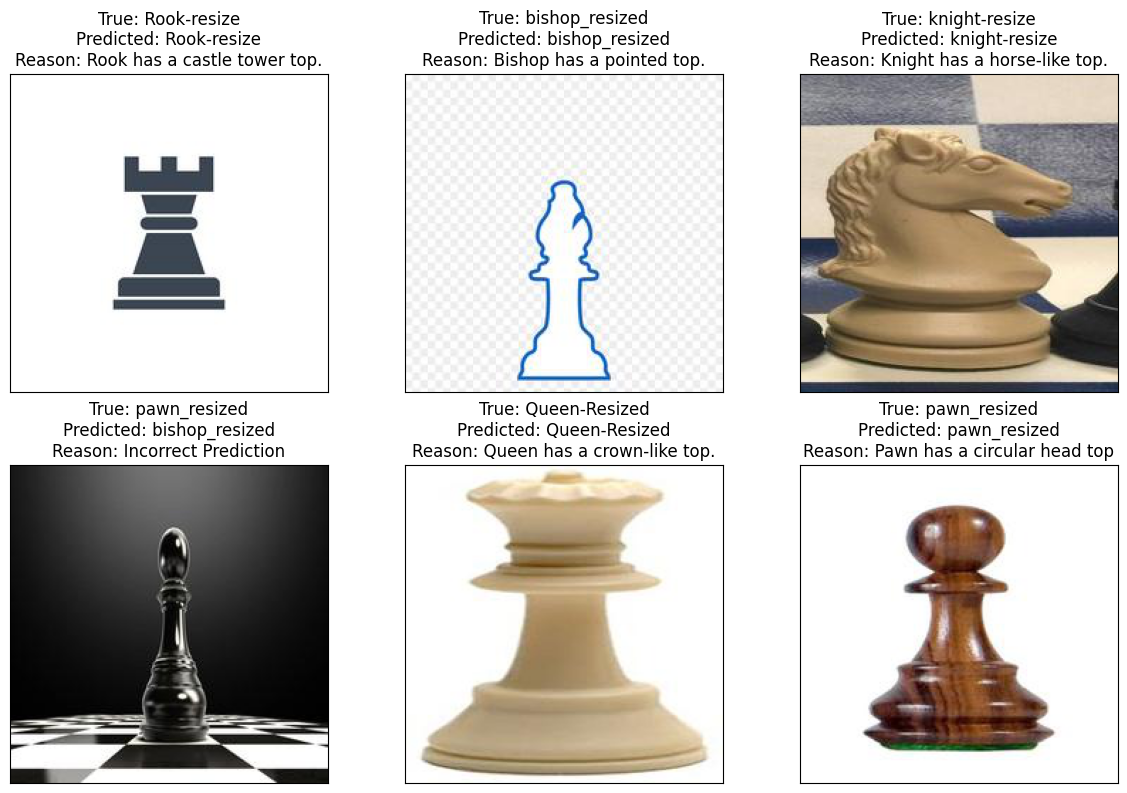

              Results 
    Test Loss:  0.88262  
Test Accuracy:  74.81%  


In [28]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = func(preprocess_input,DenseNet201,100)



In [29]:
output = pd.DataFrame({'Model':['ResNet50','InceptionResNetV2','DenseNet201 '],
                      'Accuracy':[result_ResNet50[1],result_InceptionResNetV2[1],result_DenseNet201[1]]})

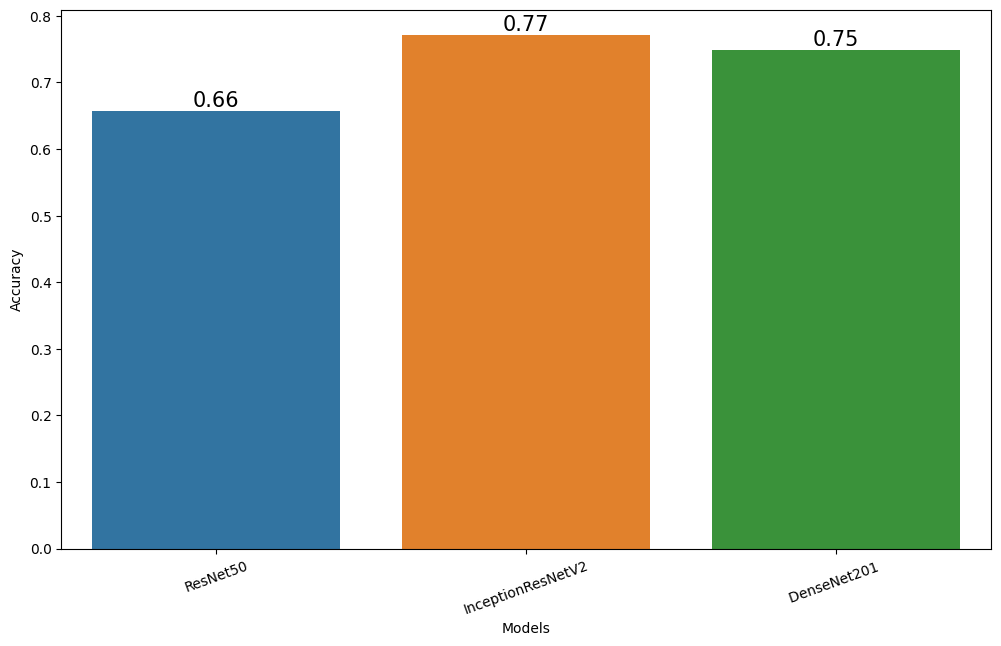

In [31]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);